### ECGbe-GAN: A novel deep learning approach for eliminating ECG interference from EMG data
Lucas Haberkamp<sup>1,2,3</sup> Charles A. Weisenbach<sup>1,2</sup> Peter Le<sup>4</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Oak Ridge Institute for Science and Education, Oak Ridge, TN, USA   
<sup>3</sup>Leidos, Reston, VA, USA   
<sup>4</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA 

#### This notebook is used to train the ECGbe-GAN deep learning model

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn import utils
from tensorflow.keras.activations import gelu
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy import signal
import time

Define Butterworth filter function

In [2]:
def butterfilter(x, Fc, Fs, ftype):
    Wn = np.asarray(Fc)/np.asarray(Fs/2)
    b, a = signal.butter(2, Wn, ftype)
    return signal.filtfilt(b,a,x)

Load in training & validation datasets

In [3]:
# Synthetic dataset
x_syn = np.load('../../Data/Training Data/ECGbe-GAN/x_syn.npy')
y_syn = np.load('../../Data/Training Data/ECGbe-GAN/y_syn.npy')
label_syn = np.load('../../Data/Training Data/ECGbe-GAN/label_syn.npy')

# Experimental dataset
x_real = np.load('../../Data/Training Data/ECGbe-GAN/x_real.npy')
y_real = np.load('../../Data/Training Data/ECGbe-GAN/y_real.npy')
label_real = np.load('../../Data/Training Data/ECGbe-GAN/label_real.npy')

# Reshape experimental data so that it has only 1 feature
x_real = np.reshape(x_real.transpose(2,0,1),(-1, x_real.shape[1],1))
y_real = np.reshape(y_real.transpose(2,0,1),(-1, y_real.shape[1],1))
label_real = np.reshape(label_real.transpose(2,0,1),(-1, label_real.shape[1],1))

# Concatenate training & experimental datasets
x_train = np.concatenate([x_syn, x_real], axis=0)
y_train = np.concatenate([y_syn, y_real], axis=0)
label_train = np.concatenate([label_syn, label_real], axis=0)

# Load an experimental trial used for validation 
df = pd.read_csv('../../Data/Training Data/ECGbe-GAN/Axial-Twist.csv')
df = df - df.mean()
df = df.apply(lambda x: butterfilter(x, Fc=500, Fs=1920, ftype='low'))

# Load synthetic validation data
x_val = np.load('../../Data/Training Data/Validation/x_val.npy')
y_val = np.load('../../Data/Training Data/Validation/y_val.npy')

Mask the ground truth data so that it does not contain QRS locations

In [4]:
y_target = []
for i in range(x_train.shape[0]):
    y_target.append(x_train[i] * label_train[i])
y_target = np.array(y_target)

In [5]:
print("x_shape:", x_train.shape)
print("y_shape:", y_train.shape)
print("y_target:", y_target.shape)
print("label_shape:", label_train.shape)

x_shape: (14000, 800, 1)
y_shape: (14000, 800, 1)
y_target: (14000, 800, 1)
label_shape: (14000, 800, 1)


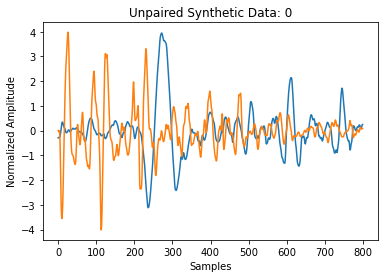

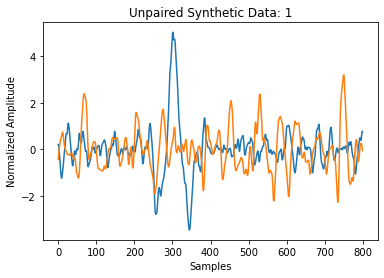

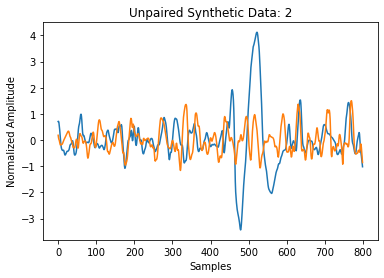

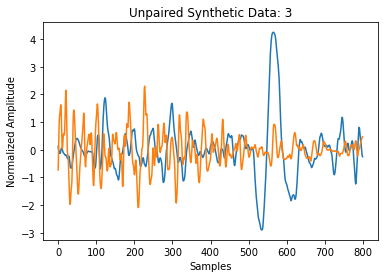

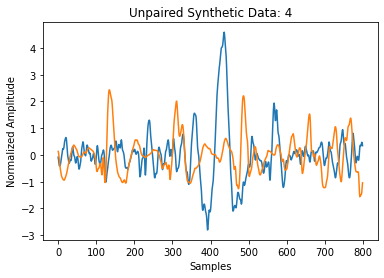

In [6]:
# Confirm the synthetic data is unpaired
for i in range(5):
  plt.plot(x_syn[i])
  plt.plot(y_syn[i])
  plt.title("Unpaired Synthetic Data: " + str(i))
  plt.xlabel("Samples")
  plt.ylabel("Normalized Amplitude")
  plt.show()

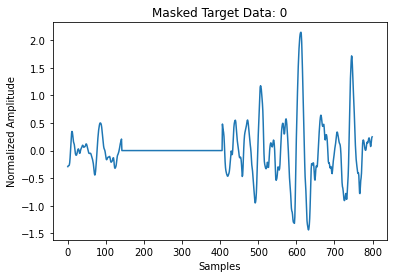

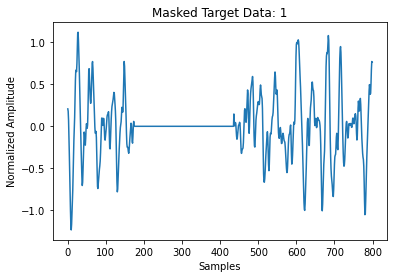

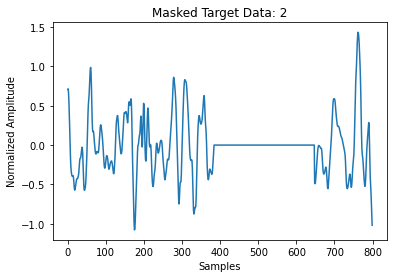

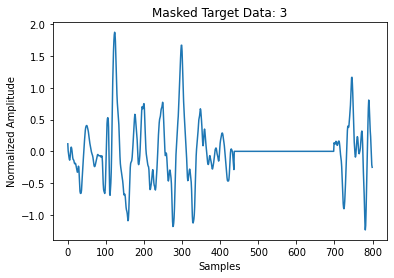

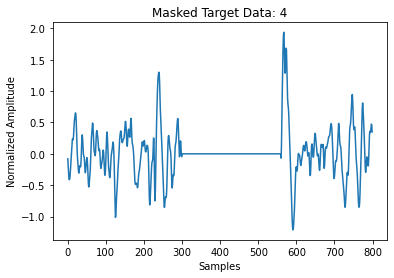

In [7]:
# Confirm the QRS complexes are masked 
for i in range(5):
    plt.plot(y_target[i])
    plt.title("Masked Target Data: " + str(i))
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.show()

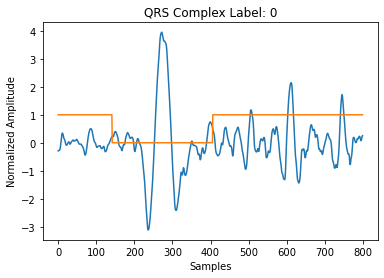

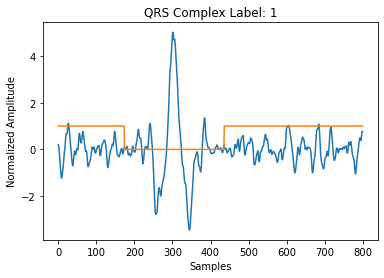

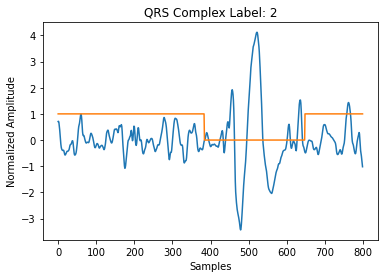

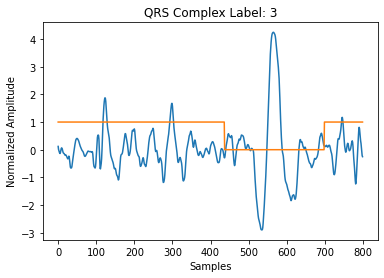

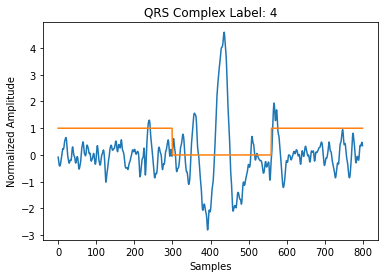

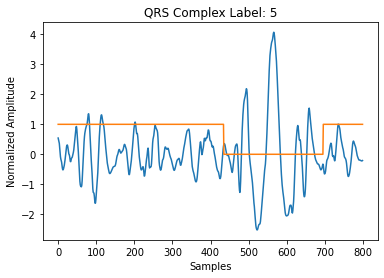

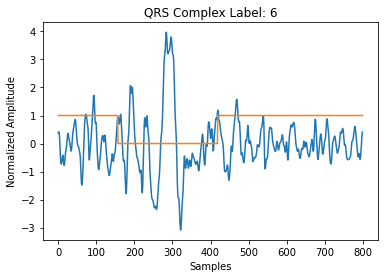

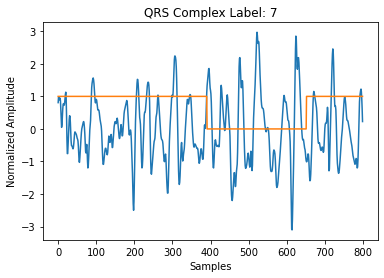

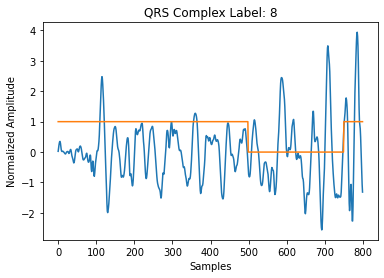

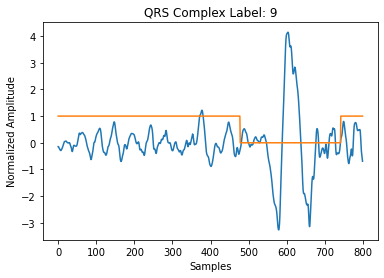

In [8]:
# Plot QRS complex locations over the contaminated data
for i in range(10):
    plt.plot(x_train[i])
    plt.plot(label_train[i])
    plt.title('QRS Complex Label: ' + str(i))
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.show()

In [9]:
del x_syn, y_syn, label_syn, x_real, y_real, label_real

Define the TCN separation module

In [10]:
def tcn_block(inputs, filters, dilation_rates, DROP):
  skips = []

  res = inputs
  for dilation in dilation_rates:
    x = LayerNormalization()(res)
    x = Conv1D(filters*3, kernel_size=1, padding='same', activation=gelu)(x)

    x = LayerNormalization()(x)
    x = SeparableConv1D(filters*3, dilation_rate=dilation,
                        kernel_size=3, padding='same', activation=gelu)(x)
    if DROP:
      x = SpatialDropout1D(0.125)(x)

    x = LayerNormalization()(x)
    x = Conv1D(filters, kernel_size=1, padding='same')(x)

    skips.append(x)
    res = Add()([x, res])

  x = Activation(gelu)(Add()(skips))
  x = LayerNormalization()(x)
  return x

Define the generator model

In [11]:
def build_generator():
  dilation_rates = [1,2,4,8,16,32,64,128] * 2

  inputs = Input(shape=(None, 1))

  x = Conv1D(filters=32, kernel_size=7, padding='same', activation=gelu)(inputs)
  x = LayerNormalization()(x)

  x = Conv1D(filters=64, strides=2, kernel_size=3, padding='same', activation=gelu)(x)
  x = SpatialDropout1D(0.125)(x)
  x = LayerNormalization()(x)

  x = Conv1D(filters=64, kernel_size=1, padding='same', activation=gelu)(x)

  sep = tcn_block(x, filters=64, dilation_rates=dilation_rates, DROP=True)
  sep = Conv1D(filters=64, kernel_size=1, padding='same', activation='sigmoid')(sep)

  mask = Multiply()([x, sep])
  mask = LayerNormalization()(mask)

  x = Conv1DTranspose(filters=32, strides=2, kernel_size=3, padding='same', activation=gelu)(mask)
  x = SpatialDropout1D(0.125)(x)
  x = LayerNormalization()(x)

  outputs = Conv1D(1, kernel_size=7, padding='same')(x)

  return Model(inputs, outputs, name='generator')

model = build_generator()
model.summary()
del model

2023-09-18 10:22:45.419132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 10:22:45.419453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 32)     256         ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 32)    64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Con

In [12]:
def build_critic():
  dilation_rates = [1,2,4,8,16,32,64,128] * 2

  inputs = Input(shape=(None, 1))

  noise = GaussianNoise(0.1)(inputs)

  x = Conv1D(filters=32, kernel_size=7, padding='same', activation=gelu)(noise)
  x = LayerNormalization()(x)

  x = Conv1D(filters=64, strides=2, kernel_size=3, padding='same', activation=gelu)(x)
  x = LayerNormalization()(x)

  x = Conv1D(filters=64, kernel_size=1, padding='same', activation=gelu)(x)

  x = tcn_block(x, filters=64, dilation_rates=dilation_rates, DROP=False)

  x = Conv1D(filters=64, kernel_size=1, padding='same', activation=gelu)(x)
  x = LayerNormalization()(x)
  x = GlobalAveragePooling1D()(x)

  outputs = Dense(1)(x)

  return Model(inputs, outputs, name='critic')

model = build_critic()
model.summary()
del model

Model: "critic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, None, 1)     0           ['input_2[0][0]']                
                                                                                                  
 conv1d_37 (Conv1D)             (None, None, 32)     256         ['gaussian_noise[0][0]']         
                                                                                                  
 layer_normalization_53 (LayerN  (None, None, 32)    64          ['conv1d_37[0][0]']              
 ormalization)                                                                               

Function to create & compile the generator & critic neural networks

In [13]:
def create_gans():

    # create building blocks
    critic = build_critic()
    generator = build_generator()

    # compile discriminators while they're set to trainable
    optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
    critic.compile(optimizer=optimizer, loss='mse')

    critic.trainable = False

    # create the first GAN architecture
    input_seq = Input(shape=(None,1))
    input_weights = Input(shape=(None,1))

    output_seq_b = generator(input_seq)
    global_out = critic(output_seq_b)
    mask_output_seq_b = Multiply(name='reconstruction')([output_seq_b, input_weights])

    GAN = Model([input_seq, input_weights], [global_out, mask_output_seq_b], name='GAN')

    optimizer = Adam(learning_rate=1e-4, beta_1=0.5)
    loss = ['mse', 'mae']
    loss_weights = [1, 10]

    GAN.compile(optimizer=optimizer, loss=loss, loss_weights=loss_weights)

    return GAN, generator, critic

Create the models

In [14]:
GAN, generator, critic = create_gans()

Function to evaluate ECGbe-GAN performance on experimental data

In [15]:
# Initialize a scaler object
scaler = StandardScaler()

def ECGbeGAN_filter(data):
    data = np.expand_dims(data, axis=1)
        
    norm_data = scaler.fit_transform(data)
    norm_data = np.expand_dims(norm_data, axis=0)
    
    y_pred = generator.predict(norm_data, verbose=0)
    y_pred = y_pred.squeeze()

    fData = scaler.inverse_transform(np.expand_dims(y_pred, axis=1)).squeeze()
    return fData

Define evaluation metric functions

In [16]:
def SNR(y_true, y_pred):
    diff = y_true - y_pred
    num = np.var(y_true)
    den = np.var(diff)
    snr = 10*np.log10(num/den)
    return snr

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def medfreq(data, Fs):
    freq, pxx = signal.periodogram(data, fs=Fs)
    pxx_cumsum = np.cumsum(pxx)
    MDF = freq[np.where(pxx_cumsum>np.max(pxx_cumsum)/2)[0][0]]
    return MDF

def MDF_RMSE(y_true, y_pred, Fs, labels=None, label_val=None):
    mdf_true, mdf_pred = [], []

    for i in range(y_pred.shape[0]):
        if labels is not None:
            mdf_true.append(medfreq(y_true[i][labels[i] == label_val].squeeze(), Fs=Fs))
            mdf_pred.append(medfreq(y_pred[i][labels[i] == label_val].squeeze(), Fs=Fs))
        else:
            mdf_true.append(medfreq(y_true[i].squeeze(), Fs=Fs))
            mdf_pred.append(medfreq(y_pred[i].squeeze(), Fs=Fs))

    mdf_true, mdf_pred = np.array(mdf_true), np.array(mdf_pred)

    return np.sqrt(np.mean((mdf_true - mdf_pred)**2))

In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Training Loop

In [18]:
# Core training loop, loads batch of sequences, generators and critics on batch
batch_size = 64

# Calculate number of batches
num_batches = x_train.shape[0] // batch_size

# total epochs 
epochs = 190

epoch_count = 0 # index of current epoch

# Empty arrays for storing loss
real_loss_all = []
fake_loss_all = []
gan_loss_all = []

while epoch_count < epochs:
    start_time = time.time() # timer for the epoch to complete

    # shuffle training data
    x_train, y_train, y_target, label_train = utils.shuffle(x_train, y_train, y_target, label_train)

    print('EPOCH: ' + str(epoch_count))

    # Get a batch of data
    batch_index = 0  # index of the current batch

    # Store per batch loss within the epoch
    real_loss = []
    fake_loss = []
    gan_loss = []

    for i in range(num_batches):
        # Select a subset of the data corresponding to the indices of the batch
        seq_a_batch = x_train[batch_index:batch_index+batch_size]
        seq_b_batch = y_train[batch_index:batch_index+batch_size]
        masked_seq_a_batch = y_target[batch_index:batch_index+batch_size]
        labels_batch = label_train[batch_index:batch_index+batch_size]

        batch_index += batch_size

        target_batch = np.ones([len(seq_a_batch),1])
        fake_batch = np.zeros([len(seq_a_batch),1]) 

        # Train critic on real data
        loss = critic.train_on_batch(seq_b_batch, target_batch)
        real_loss.append(np.expand_dims(np.array(loss), axis=0))

        # Use the generator to create predictions for the critic
        seq_b_batch_fake = generator.predict(seq_a_batch, verbose=0)

        # Train critic on fake data
        loss = critic.train_on_batch(seq_b_batch_fake, fake_batch)
        fake_loss.append(np.expand_dims(np.array(loss), axis=0))
        
        # Fit each generator
        loss = GAN.train_on_batch([seq_a_batch, labels_batch], [target_batch, masked_seq_a_batch])
        gan_loss.append(np.expand_dims(np.array(loss), axis=0))

    gan_loss = np.mean(np.concatenate(gan_loss, axis=0), axis=0)
    real_loss = np.mean(np.concatenate(real_loss, axis=0), axis=0)
    fake_loss = np.mean(np.concatenate(fake_loss, axis=0), axis=0)

    print("--- %s seconds ---" % np.round((time.time() - start_time),2))
    print("Critic Real Data:", critic.metrics_names[0], "=", real_loss)
    print("Critic Fake Data:", critic.metrics_names[0], "=", fake_loss)
    print("GAN:", GAN.metrics_names[0], "=", gan_loss[0], "-", GAN.metrics_names[1], "=", gan_loss[1], "-", GAN.metrics_names[2], "=", gan_loss[2])
    
    gan_loss_all.append(np.expand_dims(gan_loss, axis=0))
    fake_loss_all.append(np.expand_dims(fake_loss, axis=0))
    real_loss_all.append(np.expand_dims(real_loss, axis=0))

    # Validate performance every 10 epochs
    if (epoch_count % 10 == 0):

        # Save models
        MODEL_PATH = '../../Models/ECGbe-GAN/Model_Bank/critic_epoch' + str(epoch_count) + '.h5'
        critic.save(MODEL_PATH)

        MODEL_PATH = '../../Models/ECGbe-GAN/Model_Bank/generator_epoch' + str(epoch_count) + '.h5'
        generator.save(MODEL_PATH)

        # Save current training performance
        np.save('../../Models/ECGbe-GAN/Performance/real_loss.npy', np.concatenate(real_loss_all, axis=0))
        np.save('../../Models/ECGbe-GAN/Performance/fake_loss.npy', np.concatenate(fake_loss_all, axis=0))
        np.save('../../Models/ECGbe-GAN/Performance/gan_loss.npy', np.concatenate(gan_loss_all, axis=0))

        print("\nEpoch " + str(epoch_count) + " Prediction")

        # Filter experimental validation data
        filt_df = df.copy()
        filt_df = filt_df.apply(lambda x: ECGbeGAN_filter(x))

        for col in df:
            plt.plot(df[col].iloc[1500:3000])
            plt.plot(filt_df[col].iloc[1500:3000])
            plt.title(col)
            plt.show()

        # Predict on synthetic validation data
        y_pred = generator.predict(x_val, batch_size=32, verbose=0)

        plt.plot(x_val[0])
        plt.plot(y_pred[0])
        plt.title("Synthetic A>B Prediction")
        plt.show()

        # Calculate evaluation metrics
        rmse_all = RMSE(y_val, y_pred)
        print("\nRMSE Eval", rmse_all)

        mdf_rmse_all = MDF_RMSE(y_val, y_pred, Fs=1920)
        print("Median Frequency RMSE:", mdf_rmse_all, "Hz")

        snr = SNR(y_val, y_pred)
        print("Pred Signal-Noise Ratio:", snr, "\n")

    epoch_count += 1


EPOCH: 0
0 / 437


2023-09-18 10:22:56.662359: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-18 10:22:56.664796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Generate Buffer


2023-09-18 10:23:02.288238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-18 10:23:14.805785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1 / 437
2 / 437
3 / 437
4 / 437
5 / 437
6 / 437
7 / 437
8 / 437
9 / 437
10 / 437
11 / 437
12 / 437
13 / 437
14 / 437
15 / 437
16 / 437
17 / 437
18 / 437
19 / 437
20 / 437
21 / 437
22 / 437
23 / 437
24 / 437
25 / 437
26 / 437
27 / 437
28 / 437
29 / 437
30 / 437
31 / 437
32 / 437
33 / 437
34 / 437
35 / 437
36 / 437
37 / 437
38 / 437
39 / 437
40 / 437
41 / 437
42 / 437
43 / 437
44 / 437
45 / 437
46 / 437
47 / 437
48 / 437
49 / 437
50 / 437
51 / 437
52 / 437
53 / 437
54 / 437
55 / 437
56 / 437
57 / 437
58 / 437
59 / 437
60 / 437
61 / 437
62 / 437
63 / 437
64 / 437
65 / 437
66 / 437
67 / 437
68 / 437
69 / 437
70 / 437
71 / 437
72 / 437
73 / 437
74 / 437
75 / 437
76 / 437
77 / 437
78 / 437
79 / 437
80 / 437
81 / 437
82 / 437
83 / 437
84 / 437
85 / 437
86 / 437
87 / 437
88 / 437
89 / 437
90 / 437
91 / 437
92 / 437
93 / 437
94 / 437
95 / 437
96 / 437
97 / 437
98 / 437
99 / 437
100 / 437
101 / 437
102 / 437
103 / 437
104 / 437
105 / 437
106 / 437
107 / 437
108 / 437
109 / 437
110 / 437
111 / 43

KeyboardInterrupt: 